Brief architecture:

Data preprocessing ( pipeline ):
Removing duplicates
Removing some missing data
Removing outliers ( z-score )
Imputing missing data for relevant fields as runtime, theatre date
Transforming the data as genre, rating (for relevant values)
Adding new relevant columns as theatre year..
Encoding categorical values (one - hot encoding, ordinal encoding)
Scaling the data ( standard scaler , min-max scaler )
Handling Imbalances ( SMOTE )
Feature selection ( PCA, manual selection )

Model:
Regression model ( using random forest, xgboost, Feedforward NN(linear) )
Classification model (Feedforward NN(soft max) )
Semantic model ( sentence transformer: all-MiniLM-L6-v2,Feedforward NN &  xgboost )

Metrics:
MAE
Tolerance accuracy

Please find doc link for explaination and inferences : https://docs.google.com/document/d/1PL6G-HlWOmCGfYIgOqRAm7a7u9vsV3H9lfXjHjSS5wk/edit?usp=sharing

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!pip install scikit-learn==1.3.2
!pip install imblearn

In [3]:
dataset = pd.read_csv("./Rotten_Tomatoes_Movies3.csv")

In [4]:
dataset.columns

Index(['movie_title', 'movie_info', 'critics_consensus', 'rating', 'genre',
       'directors', 'writers', 'cast', 'in_theaters_date', 'on_streaming_date',
       'runtime_in_minutes', 'studio_name', 'tomatometer_status',
       'tomatometer_rating', 'tomatometer_count', 'audience_rating'],
      dtype='object')

In [5]:
dataset.head()

,movie_title,movie_info,critics_consensus,rating,genre,directors,writers,cast,in_theaters_date,on_streaming_date,runtime_in_minutes,studio_name,tomatometer_status,tomatometer_rating,tomatometer_count,audience_rating
0,Percy Jackson & the Olympians: The Lightning T...,A teenager discovers he's the descendant of a ...,Though it may seem like just another Harry Pot...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,Craig Titley,"Logan Lerman, Brandon T. Jackson, Alexandra Da...",2/12/2010,6/29/2010,83.0,20th Century Fox,Rotten,49,144,53.0
1,Please Give,Kate has a lot on her mind. There's the ethics...,Nicole Holofcener's newest might seem slight i...,R,Comedy,Nicole Holofcener,Nicole Holofcener,"Catherine Keener, Amanda Peet, Oliver Platt, R...",4/30/2010,10/19/2010,90.0,Sony Pictures Classics,Certified Fresh,86,140,64.0
2,10,Blake Edwards' 10 stars Dudley Moore as George...,NaN,R,"Comedy, Romance",Blake Edwards,Blake Edwards,"Dudley Moore, Bo Derek, Julie Andrews, Robert ...",10/5/1979,8/27/1997,118.0,Waner Bros.,Fresh,68,22,53.0
3,12 Angry Men (Twelve Angry Men),"A Puerto Rican youth is on trial for murder, a...",Sidney Lumet's feature debut is a superbly wri...,NR,"Classics, Drama",Sidney Lumet,Reginald Rose,"Martin Balsam, John Fiedler, Lee J. Cobb, E.G....",4/13/1957,3/6/2001,95.0,Criterion Collection,Certified Fresh,100,51,97.0
4,"20,000 Leagues Under The Sea","This 1954 Disney version of Jules Verne's 20,0...","One of Disney's finest live-action adventures,...",G,"Action & Adventure, Drama, Kids & Family",Richard Fleischer,Earl Felton,"James Mason, Kirk Douglas, Paul Lukas, Peter L...",1/1/1954,5/20/2003,127.0,Disney,Fresh,89,27,74.0


In [5]:
cleaned_data = dataset['audience_rating'].dropna()
is_discrete = all(cleaned_data % 1 == 0)
print(is_discrete)

True


Above code snippet confirms that rating is given as a discrete variable(classification) instead of regression

In [6]:
print("\n--- Checking for Duplicates ---")
duplicate_movies = dataset['movie_title'].duplicated().sum()
duplicates = dataset.duplicated().sum()
print(f"Number of Duplicate movies: {duplicate_movies}")
print(f"Number of Duplicate Rows: {duplicates}")


--- Checking for Duplicates ---
Number of Duplicate movies: 532
Number of Duplicate Rows: 1


In [7]:
duplicate_rows = dataset[dataset.duplicated(keep=False)]
# print(duplicate_rows)
dataset = dataset.drop_duplicates(keep=False).reset_index(drop=True)

In [8]:
combined_column = dataset[['movie_title', 'in_theaters_date']]
duplicates_combined = combined_column.duplicated(keep=False).sum()
print(duplicates_combined)

4


- There are around 500 duplicates in respect to movie titles
- But when it is combined with features as in_theatres_date they've drastically reduced to 4
- which can be ignored , since for a movie can be re-released with same name later which is having different review

In [106]:
for col in dataset.columns: 
        print(col,":")
        # Missing values
        missing_vals = dataset[col].isnull().sum()
        missing_pct = (missing_vals / len(dataset)) * 100
        print(f"Missing Values: {missing_vals} ({missing_pct:.2f}%)")
        
        # Number of unique values
        unique_vals = dataset[col].nunique()
        print(f"Number of Unique Values: {unique_vals}")


movie_title :
Missing Values: 0 (0.00%)
Number of Unique Values: 16105
movie_info :
Missing Values: 24 (0.14%)
Number of Unique Values: 16612
critics_consensus :
Missing Values: 8327 (50.05%)
Number of Unique Values: 8307
rating :
Missing Values: 0 (0.00%)
Number of Unique Values: 8
genre :
Missing Values: 17 (0.10%)
Number of Unique Values: 1080
directors :
Missing Values: 114 (0.69%)
Number of Unique Values: 8314
writers :
Missing Values: 1349 (8.11%)
Number of Unique Values: 12120
cast :
Missing Values: 284 (1.71%)
Number of Unique Values: 16325
in_theaters_date :
Missing Values: 815 (4.90%)
Number of Unique Values: 5585
on_streaming_date :
Missing Values: 2 (0.01%)
Number of Unique Values: 2260
runtime_in_minutes :
Missing Values: 155 (0.93%)
Number of Unique Values: 201
studio_name :
Missing Values: 414 (2.49%)
Number of Unique Values: 2886
tomatometer_status :
Missing Values: 0 (0.00%)
Number of Unique Values: 3
tomatometer_rating :
Missing Values: 0 (0.00%)
Number of Unique Valu

Inference from above:
- There are some data with missing audience rating (1.5%), can use them in test data but since the fraction is too low removing will ensure data sanity ( same for 'genre' column)
- Missing data is very high (almost 50%) in critic consensus hence we'll remove that column for baseline model
- We can impute the data accordingly for runtime, theatre dates

In [9]:
dataset = dataset.dropna(subset=['genre']).reset_index(drop=True)

In [10]:
dataset = dataset.dropna(subset=['audience_rating']).reset_index(drop=True)

In [11]:
dataset = dataset.dropna(subset=['in_theaters_date', 'on_streaming_date'], how='all').reset_index(drop=True)

In [15]:
print(dataset['runtime_in_minutes'].min())
print(dataset['runtime_in_minutes'].max())
print(len(dataset[dataset['runtime_in_minutes']<20]))
print(len(dataset[dataset['runtime_in_minutes']>250]))
print(dataset['runtime_in_minutes'].isna().sum())

1.0
2000.0
17
10
147


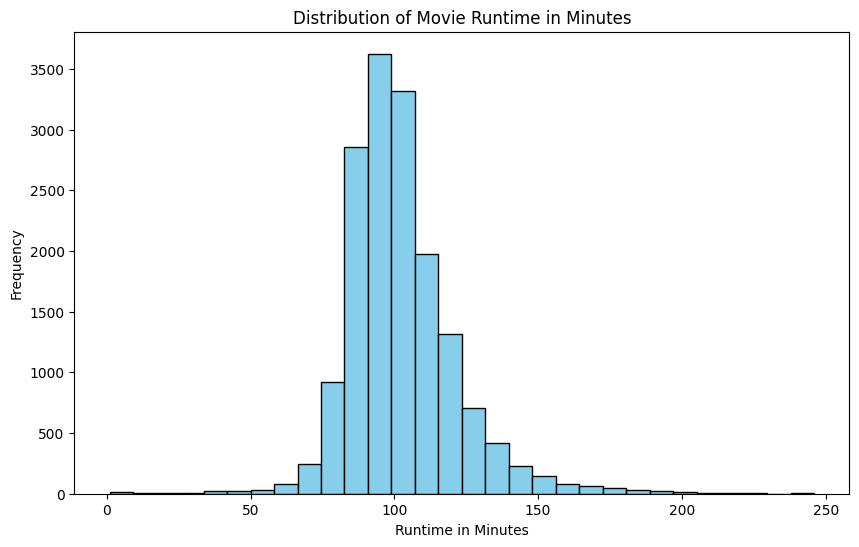

In [16]:
plt.figure(figsize=(10, 6))
plt.hist(dataset['runtime_in_minutes'][dataset['runtime_in_minutes'] < 250].dropna(), bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Runtime in Minutes')
plt.ylabel('Frequency')
plt.title('Distribution of Movie Runtime in Minutes')
plt.show()

Imputing data for runtime using the median which won't be effected by the outliers

In [12]:
runtime_median = dataset['runtime_in_minutes'].median()
dataset['runtime_in_minutes'].fillna(runtime_median, inplace=True)

In [13]:
from scipy.stats import zscore
runtime_non_null = dataset['runtime_in_minutes']
z_scores = zscore(runtime_non_null)
outliers_z = runtime_non_null[abs(z_scores) > 3]
print("Outliers using Z-Score method:")
print(len(outliers_z))

Outliers using Z-Score method:
151


30.0
177.0


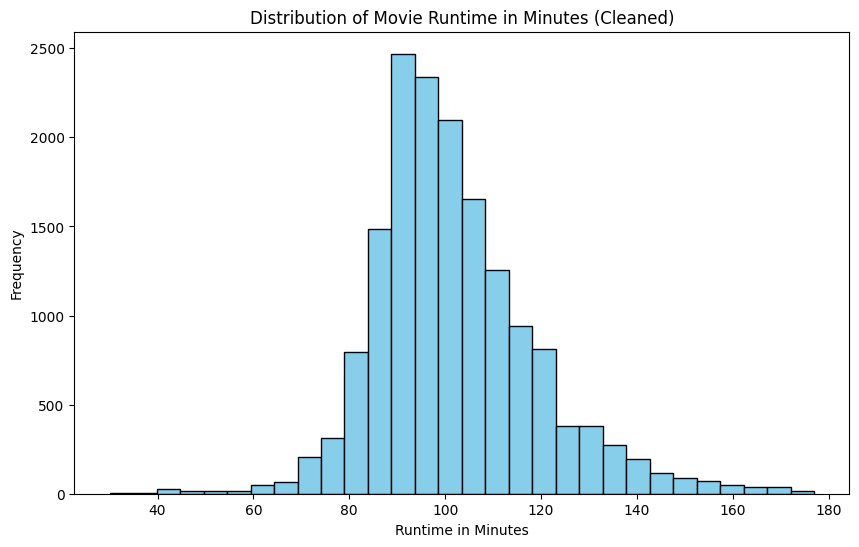

In [14]:
outlier_mask = abs(z_scores) > 3
dataset = dataset[~outlier_mask].reset_index(drop=True)
print(dataset['runtime_in_minutes'].min())
print(dataset['runtime_in_minutes'].max())
plt.figure(figsize=(10, 6))
plt.hist(dataset['runtime_in_minutes'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Runtime in Minutes')
plt.ylabel('Frequency')
plt.title('Distribution of Movie Runtime in Minutes (Cleaned)')
plt.show()

In [81]:
print("dataset after removing outliers, duplicates and missing data")
print(len(dataset))

dataset after removing outliers, duplicates and missing data
16215


In [21]:
dataset['genre'].loc[0:10]

0     Action & Adventure, Comedy, Drama, Science Fic...
1                                                Comedy
2                                       Comedy, Romance
3                                       Classics, Drama
4              Action & Adventure, Drama, Kids & Family
5                   Action & Adventure, Classics, Drama
6      Action & Adventure, Classics, Mystery & Suspense
7                              Classics, Drama, Western
8                                Comedy, Drama, Romance
9                                       Classics, Drama
10    Art House & International, Horror, Mystery & S...
Name: genre, dtype: object

In [15]:
unique_genres = set()
for i in range(len(dataset)):
    genres = dataset['genre'].loc[i].split(",")
    for j in genres:
        unique_genres.add(j.strip().lower())

print(len(unique_genres))
print(unique_genres)


21
{'classics', 'science fiction & fantasy', 'cult movies', 'romance', 'documentary', 'mystery & suspense', 'kids & family', 'musical & performing arts', 'television', 'comedy', 'art house & international', 'animation', 'action & adventure', 'faith & spirituality', 'gay & lesbian', 'anime & manga', 'western', 'special interest', 'sports & fitness', 'horror', 'drama'}


After extracting the unique sub genres from the data, we'll use one-hot encoding for embedding the data for various genres

In [16]:
unique_genres = sorted(unique_genres)
for genre in unique_genres:
    dataset[genre] = dataset['genre'].apply(lambda x: 1 if genre in x.strip().lower() else 0)

In [17]:
dataset['rating'].unique()

array(['PG', 'R', 'NR', 'G', 'PG-13', 'PG-13)', 'NC17', 'R)'],
      dtype=object)

In [18]:
dataset['rating'] = dataset['rating'].apply(lambda x: x[:-1] if x.endswith(')') else x)

In [19]:
dataset['in_theaters_date'] = pd.to_datetime(dataset['in_theaters_date'], errors='coerce')
dataset['on_streaming_date'] = pd.to_datetime(dataset['on_streaming_date'], errors='coerce')

In [20]:
theatre_only = dataset[dataset['in_theaters_date'].notna() & dataset['on_streaming_date'].isna()]
stream_only = dataset[dataset['on_streaming_date'].notna() & dataset['in_theaters_date'].isna()]
neither = dataset[dataset['in_theaters_date'].isna() & dataset['on_streaming_date'].isna()]

print("Movies with theatre_date but no stream_date:")
print(len(theatre_only['movie_title']))

print("\nMovies with stream_date but no theatre_date:")
print(len(stream_only['movie_title']))

print("\nMovies with neither theatre_date nor stream_date:")
print(len(neither['movie_title']))
valid_lags = dataset
average_lag = (valid_lags['on_streaming_date'] - valid_lags['in_theaters_date']).dt.days.mean()

print("\nAverage lag between theatre_date and stream_date (in days):")
print(average_lag)

Movies with theatre_date but no stream_date:
0

Movies with stream_date but no theatre_date:
701

Movies with neither theatre_date nor stream_date:
0

Average lag between theatre_date and stream_date (in days):
3116.2306948562587


From above inference:
- Average delay in theatre, stream is 3000 days ( approx 10 years ) due to old movies being released late
- I initially thought of taking difference between theatre date, stream date which has correlation to movie's hype/ box office performance
- Since the delay is too high, we can't take that for inferencing the audience rating (same is the case for movies directly streamed without theatrical release)
- Also we can impute the missing theatre date with stream date - average lag (based on data)
- But there might be a chance where the movie was directly shown on TV, hence we can't do the same
- So for missing data, I've equated streaming date to theatre date
- For capturing the trend of movies, I've taken year instead of day to maintain sparse relations ( avoiding overfitting )

In [21]:
dataset.loc[dataset['in_theaters_date'].isna() & dataset['on_streaming_date'].notna(), 'in_theaters_date'] = dataset['on_streaming_date']
dataset['theatre_year'] = dataset['in_theaters_date'].dt.year
dataset['stream_year'] = dataset['on_streaming_date'].dt.year


In [120]:
dataset.describe()

,in_theaters_date,on_streaming_date,runtime_in_minutes,tomatometer_rating,tomatometer_count,audience_rating,action & adventure,animation,anime & manga,art house & international,...,musical & performing arts,mystery & suspense,romance,science fiction & fantasy,special interest,sports & fitness,television,western,theatre_year,stream_year
count,16064,16064,16064.000000,16064.000000,16064.000000,16064.000000,16064.000000,16064.000000,16064.000000,16064.000000,...,16064.000000,16064.000000,16064.000000,16064.000000,16064.000000,16064.000000,16064.000000,16064.000000,16064.000000,16064.000000
mean,2000-05-24 16:14:34.900398336,2008-07-22 01:51:25.458167296,101.804096,60.167082,57.420443,60.315115,0.203312,0.033989,0.000934,0.144422,...,0.057395,0.203187,0.109562,0.105827,0.072896,0.010583,0.014691,0.017119,1999.903386,2008.063496
min,1915-01-01 00:00:00,1935-06-06 00:00:00,30.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1915.000000,1935.000000
25%,1994-04-15 00:00:00,2003-01-21 00:00:00,90.000000,38.000000,12.000000,44.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1994.000000,2003.000000
50%,2007-01-02 12:00:00,2008-03-18 00:00:00,99.000000,65.000000,29.000000,62.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2006.500000,2008.000000
75%,2013-10-04 00:00:00,2014-04-01 00:00:00,110.000000,85.000000,78.000000,77.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2013.000000,2014.000000
max,2019-10-25 00:00:00,2019-11-01 00:00:00,177.000000,100.000000,497.000000,100.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2019.000000,2019.000000
std,NaN,NaN,17.204977,28.572880,66.660330,20.431489,0.402475,0.181207,0.030544,0.351528,...,0.232604,0.402383,0.312352,0.307625,0.259974,0.102330,0.120318,0.129719,19.153648,6.462209


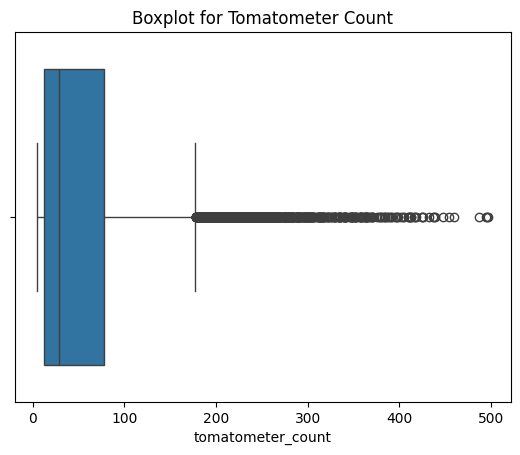

In [327]:
sns.boxplot(x=dataset['tomatometer_count'])
plt.title("Boxplot for Tomatometer Count")
plt.show()

In [122]:
from scipy.stats import zscore
tomatometer_count = dataset['tomatometer_count']
z_scores = zscore(tomatometer_count)
outliers_t = tomatometer_count[abs(z_scores) > 3]
print(f"Number of outliers: {len(outliers_t)}")

Number of outliers: 302


Need to check the removal of outliers in tomatometer_count based on results -- tree(robust to outliers) vs distance based techniques

In [22]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder(categories=[['Rotten', 'Certified Fresh', 'Fresh']])
dataset['status'] = ordinal_encoder.fit_transform(dataset[['tomatometer_status']])
ordinal_encoder = OrdinalEncoder(categories=[['PG', 'R', 'NR', 'G', 'PG-13', 'NC17']]) 
dataset['rating_encoded'] = ordinal_encoder.fit_transform(dataset[['rating']])

In [23]:

from sklearn.preprocessing import StandardScaler, MinMaxScaler
standard_scaler = StandardScaler()
min_max_scaler = MinMaxScaler()
dataset['runtime_in_minutes_scaled'] = standard_scaler.fit_transform(dataset[['runtime_in_minutes']])
dataset[['tomatometer_count_scaled', 'theatre_year_scaled', 'stream_year_scaled', 'tomatometer_rating_scaled']] = min_max_scaler.fit_transform(dataset[['tomatometer_count', 'theatre_year', 'stream_year','tomatometer_rating']])

In [24]:
# Drop unnecessary columns
columns_to_drop = ['movie_title', 'movie_info', 'critics_consensus', 'directors', 
                   'writers', 'cast', 'in_theaters_date', 'on_streaming_date', 'studio_name', 'genre', 'tomatometer_status', 'rating', 'runtime_in_minutes', 'tomatometer_count','theatre_year', 'stream_year','tomatometer_rating']
dataset = dataset.drop(columns=columns_to_drop, errors='ignore')

In [25]:
dataset.columns

Index(['audience_rating', 'action & adventure', 'animation', 'anime & manga',
       'art house & international', 'classics', 'comedy', 'cult movies',
       'documentary', 'drama', 'faith & spirituality', 'gay & lesbian',
       'horror', 'kids & family', 'musical & performing arts',
       'mystery & suspense', 'romance', 'science fiction & fantasy',
       'special interest', 'sports & fitness', 'television', 'western',
       'status', 'rating_encoded', 'runtime_in_minutes_scaled',
       'tomatometer_count_scaled', 'theatre_year_scaled', 'stream_year_scaled',
       'tomatometer_rating_scaled'],
      dtype='object')

Handling data imbalances

audience_rating
0.0       5
4.0       2
5.0       5
6.0       2
7.0       4
         ..
96.0     28
97.0     16
98.0      6
99.0      3
100.0    25
Name: count, Length: 98, dtype: int64


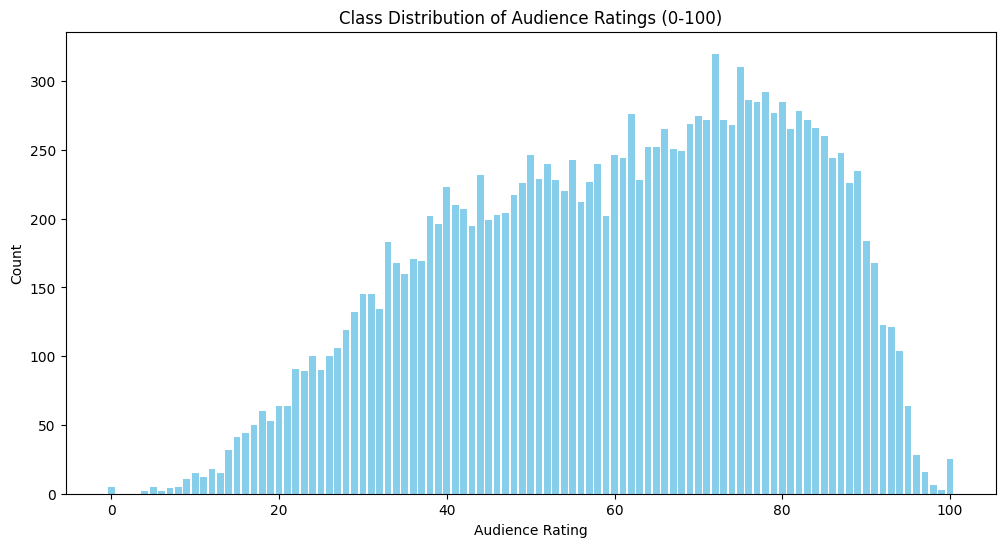

In [26]:
# Check class counts
class_counts = dataset['audience_rating'].value_counts().sort_index()
print(class_counts)

plt.figure(figsize=(12, 6))
plt.bar(class_counts.index, class_counts.values, color='skyblue')
plt.title("Class Distribution of Audience Ratings (0-100)")
plt.xlabel("Audience Rating")
plt.ylabel("Count")
plt.show()


In [27]:
from imblearn.over_sampling import SMOTE
X = dataset.drop(columns=['audience_rating'])
y = dataset['audience_rating']
class_counts = y.value_counts()
print("Class distribution before resampling:")
print(class_counts)
smote = SMOTE(random_state=42, k_neighbors=1)  # Since for some classes there're too low samples
X_resampled, y_resampled = smote.fit_resample(X, y)

Class distribution before resampling:
audience_rating
72.0    320
75.0    310
78.0    292
76.0    286
77.0    285
       ... 
8.0       5
7.0       4
99.0      3
4.0       2
6.0       2
Name: count, Length: 98, dtype: int64


In [130]:
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

model_rf = RandomForestRegressor(random_state=42)
model_rf.fit(X_resampled, y_resampled)
perm_importance = permutation_importance(
    model_rf, X_resampled, y_resampled, n_repeats=10, random_state=42, scoring='r2'
)
sorted_idx = perm_importance.importances_mean.argsort()
print("Feature Importance (sorted):")
for i in sorted_idx:
    print(f"{X_resampled.columns[i]}: {perm_importance.importances_mean[i]:.4f}")
important_features = [
    X_resampled.columns[i]
    for i in sorted_idx
    if perm_importance.importances_mean[i] > 0.005
]
print(f"Selected Features (Importance > 0.005): {important_features}")


#checking inter-feature dependence (multi collinearity)
vif_data = pd.DataFrame()
vif_data["feature"] = X_resampled.columns
vif_data["VIF"] = [
    variance_inflation_factor(X_resampled.values, i)
    for i in range(X_resampled.shape[1])
]

print("Variance Inflation Factor (VIF):")
print(vif_data)

columns_to_drop_vif = vif_data[vif_data["VIF"] > 10]["feature"].tolist()
print(f"Features to Drop due to High VIF: {columns_to_drop_vif}")

Feature Importance (sorted):
anime & manga: 0.0000
cult movies: 0.0001
gay & lesbian: 0.0001
faith & spirituality: 0.0002
sports & fitness: 0.0002
western: 0.0004
classics: 0.0006
animation: 0.0009
musical & performing arts: 0.0013
special interest: 0.0016
science fiction & fantasy: 0.0020
romance: 0.0027
kids & family: 0.0035
art house & international: 0.0047
action & adventure: 0.0068
horror: 0.0104
television: 0.0120
mystery & suspense: 0.0136
comedy: 0.0521
drama: 0.0695
documentary: 0.0721
theatre_year_scaled: 0.0997
rating_encoded: 0.1082
stream_year_scaled: 0.1616
tomatometer_count_scaled: 0.1893
status: 0.1974
runtime_in_minutes_scaled: 0.2712
tomatometer_rating: 0.9340
Selected Features (Importance > 0.005): ['action & adventure', 'horror', 'television', 'mystery & suspense', 'comedy', 'drama', 'documentary', 'theatre_year_scaled', 'rating_encoded', 'stream_year_scaled', 'tomatometer_count_scaled', 'status', 'runtime_in_minutes_scaled', 'tomatometer_rating']
Variance Inflation

Based on aboove results, manually dropping some of the features which have low relevance and redundant from other features

In [37]:

columns_to_drop = [
    'western',
    'faith & spirituality',
    'anime & manga',
    'gay & lesbian',
    'cult movies',
    'sports & fitness',
    'stream_year_scaled',
    'classics',
    'animation',

]
X_resampled_final_manual_drop = X_resampled.drop(columns=columns_to_drop)

Using PCA for selecting features:

In [30]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95, random_state=42)
X_resampled_final = pca.fit_transform(X_resampled)

In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled_final, y_resampled, test_size=0.2, random_state=42
)

In [38]:
X_train_manual, X_test_manual, y_train_manual, y_test_manual = train_test_split(
    X_resampled_final_manual_drop, y_resampled, test_size=0.2, random_state=42
)

Random forest model using PCA for feature selection

In [34]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae}")
y_pred_rounded = np.round(y_pred)
rounded_accuracy = (y_pred_rounded == y_test).mean()
print(f"Rounded Accuracy: {rounded_accuracy}")
tolerance_3_accuracy = ((np.abs(y_pred - y_test) <= 3).sum() / len(y_test)) * 100
tolerance_5_accuracy = ((np.abs(y_pred - y_test) <= 5).sum() / len(y_test)) * 100

print(f"Tolerance Accuracy (±3): {tolerance_3_accuracy:.2f}%")
print(f"Tolerance Accuracy (±5): {tolerance_5_accuracy:.2f}%")


MAE: 8.265685586734694
Rounded Accuracy: 0.15003188775510204
Tolerance Accuracy (±3): 35.30%
Tolerance Accuracy (±5): 47.40%


Random forest using manual feature selection through VIF, perm importance

In [40]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_manual, y_train_manual)
y_pred = model.predict(X_test_manual)
mae = mean_absolute_error(y_test_manual, y_pred)
print(f"MAE: {mae}")

y_pred_rounded = np.round(y_pred)
rounded_accuracy = (y_pred_rounded == y_test_manual).mean()
print(f"Rounded Accuracy: {rounded_accuracy}")

tolerance_3_accuracy = ((np.abs(y_pred - y_test_manual) <= 3).sum() / len(y_test_manual)) * 100
tolerance_5_accuracy = ((np.abs(y_pred - y_test_manual) <= 5).sum() / len(y_test_manual)) * 100

print(f"Tolerance Accuracy (±3): {tolerance_3_accuracy:.2f}%")
print(f"Tolerance Accuracy (±5): {tolerance_5_accuracy:.2f}%")


MAE: 7.974329931972789
Rounded Accuracy: 0.14301658163265307
Tolerance Accuracy (±3): 35.76%
Tolerance Accuracy (±5): 48.37%


XG Boost model

In [41]:
from sklearn.model_selection import  GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, scoring='neg_mean_absolute_error', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best Parameters:", best_params)

best_xgb = grid_search.best_estimator_

y_pred = best_xgb.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"R² Score: {r2}")

y_pred_rounded = np.round(y_pred)
rounded_accuracy = (y_pred_rounded == y_test).mean()
print(f"Rounded Accuracy: {rounded_accuracy}")

tolerance_3_accuracy = ((np.abs(y_pred - y_test) <= 3).sum() / len(y_test)) * 100
tolerance_5_accuracy = ((np.abs(y_pred - y_test) <= 5).sum() / len(y_test)) * 100

print(f"Tolerance Accuracy (±3): {tolerance_3_accuracy:.2f}%")
print(f"Tolerance Accuracy (±5): {tolerance_5_accuracy:.2f}%")

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0}
MAE: 8.920864141011036
MSE: 158.1536359146956
R² Score: 0.8015766109214808
Rounded Accuracy: 0.06712372448979592
Tolerance Accuracy (±3): 30.74%
Tolerance Accuracy (±5): 44.01%


In [42]:
tolerance_10_accuracy = ((np.abs(y_pred - y_test) <= 5).sum() / len(y_test)) * 100
tolerance_15_accuracy = ((np.abs(y_pred - y_test) <= 7).sum() / len(y_test)) * 100

print(f"Tolerance Accuracy (±5): {tolerance_10_accuracy:.2f}%")
print(f"Tolerance Accuracy (±7): {tolerance_15_accuracy:.2f}%")

Tolerance Accuracy (±5): 44.01%
Tolerance Accuracy (±7): 53.62%


Feed forward neural network

In [43]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam


In [45]:
X_train = X_train_manual
X_test = X_test_manual
y_test = y_test_manual
y_train = y_train_manual

In [46]:

model = Sequential()
model.add(Dense(16, activation='relu', input_shape=(19,)))
model.add(BatchNormalization())
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))


model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])


model.summary()

history = model.fit(
    X_train, 
    y_train, 
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    verbose=1,
)

loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")


c:\Users\lashicr7\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 16)             │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 529 (2.07 KB)

 Trainable params: 497 (1.94 KB)

 Non-trainable params: 32 (128.00 B)

Epoch 1/200
628/628 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 2712.1270 - mae: 44.6877 - val_loss: 393.4956 - val_mae: 15.8651
Epoch 2/200
628/628 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 379.1059 - mae: 15.3905 - val_loss: 282.4833 - val_mae: 12.8517
Epoch 3/200
628/628 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 273.6189 - mae: 12.8234 - val_loss: 265.2467 - val_mae: 12.3597
Epoch 4/200
628/628 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 275.3049 - mae: 12.8654 - val_loss: 259.3189 - val_mae: 12.0748
Epoch 5/200
628/628 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 263.6676 - mae: 12.5186 - val_loss: 254.2563 - val_mae: 12.1482
Epoch 6/200
628/628 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 253.2450 - mae: 12.3689 - val_loss: 252.0188 - val_mae: 12.0386
Epoch 7/200
628/628 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 257.7725 - mae: 12.4144 - val_loss: 254.4786 - val_mae: 11.8864
Epoch 8/200
628/628 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 252.9799 - mae: 12.3087 - val_loss: 250.1924 - val_mae: 11.9998

In [47]:
y_pred = model.predict(X_test).flatten()
tolerance_3_accuracy = ((np.abs(y_pred - y_test) <= 3).sum() / len(y_test)) * 100
tolerance_5_accuracy = ((np.abs(y_pred - y_test) <= 5).sum() / len(y_test)) * 100

print(f"Tolerance Accuracy (±3): {tolerance_3_accuracy:.2f}%")
print(f"Tolerance Accuracy (±5): {tolerance_5_accuracy:.2f}%")

196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Tolerance Accuracy (±3): 19.04%
Tolerance Accuracy (±5): 30.96%


SEMANTIC MODEL ( we take movie info(to understand context/ story line), which may also have influence on the movie result)

In [65]:
import pandas as pd
df = pd.read_csv('Rotten_Tomatoes_Movies3.csv')

In [156]:
df.columns

Index(['movie_title', 'movie_info', 'critics_consensus', 'rating', 'genre',
       'directors', 'writers', 'cast', 'in_theaters_date', 'on_streaming_date',
       'runtime_in_minutes', 'studio_name', 'tomatometer_status',
       'tomatometer_rating', 'tomatometer_count', 'audience_rating'],
      dtype='object')

In [1]:
!pip install tensorflow==2.18.0 tf-keras transformers
!pip install sentence-transformers


Note: you may need to restart the kernel to use updated packages.


In [7]:
import pandas as pd
from sentence_transformers import SentenceTransformer
import numpy as np

sentence_model = SentenceTransformer('all-MiniLM-L6-v2') 
def compute_sentence_embeddings(texts):
    """Compute sentence embeddings for a list of texts."""
    embeddings = []
    for text in texts:
        if not text or pd.isna(text): 
            embeddings.append(np.zeros(sentence_model.get_sentence_embedding_dimension()))
        else:
            embedding = sentence_model.encode(text, show_progress_bar=False)
            embeddings.append(embedding)
    return np.array(embeddings)
movie_info_embeddings = compute_sentence_embeddings(df['movie_info'])


Use this code for saving embeddings and reloading which can help in modular code running

In [9]:
np.savetxt('sentence_embeddings.txt', movie_info_embeddings, delimiter=' ')
loaded_data = np.loadtxt('sentence_embeddings.txt', delimiter=' ')
print(loaded_data.shape) 
print(np.array_equal( movie_info_embeddings, loaded_data))

(16638, 384)
True


In [14]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95, random_state=42)
reduced_embeddings = pca.fit_transform(movie_info_embeddings)

In [15]:
reduced_embeddings.shape

(16638, 218)

In [66]:
embeddings_df = pd.DataFrame(reduced_embeddings)
df = pd.concat([df, embeddings_df], axis=1)

In [67]:
df.head()

,movie_title,movie_info,critics_consensus,rating,genre,directors,writers,cast,in_theaters_date,on_streaming_date,...,208,209,210,211,212,213,214,215,216,217
0,Percy Jackson & the Olympians: The Lightning T...,A teenager discovers he's the descendant of a ...,Though it may seem like just another Harry Pot...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,Craig Titley,"Logan Lerman, Brandon T. Jackson, Alexandra Da...",2/12/2010,6/29/2010,...,-0.006604,0.004451,0.010701,0.027692,0.026795,-0.048007,0.068290,0.011586,-0.007773,-0.004174
1,Please Give,Kate has a lot on her mind. There's the ethics...,Nicole Holofcener's newest might seem slight i...,R,Comedy,Nicole Holofcener,Nicole Holofcener,"Catherine Keener, Amanda Peet, Oliver Platt, R...",4/30/2010,10/19/2010,...,-0.017481,0.028921,-0.010660,-0.002627,0.022829,-0.046013,-0.028977,-0.035879,0.042951,-0.063410
2,10,Blake Edwards' 10 stars Dudley Moore as George...,NaN,R,"Comedy, Romance",Blake Edwards,Blake Edwards,"Dudley Moore, Bo Derek, Julie Andrews, Robert ...",10/5/1979,8/27/1997,...,-0.008803,-0.027856,0.000888,0.020838,0.044571,-0.064736,-0.010670,-0.003647,-0.014654,-0.003085
3,12 Angry Men (Twelve Angry Men),"A Puerto Rican youth is on trial for murder, a...",Sidney Lumet's feature debut is a superbly wri...,NR,"Classics, Drama",Sidney Lumet,Reginald Rose,"Martin Balsam, John Fiedler, Lee J. Cobb, E.G....",4/13/1957,3/6/2001,...,-0.007631,0.036879,0.035361,-0.007004,-0.004631,-0.044865,0.002537,-0.022569,0.013458,0.020489
4,"20,000 Leagues Under The Sea","This 1954 Disney version of Jules Verne's 20,0...","One of Disney's finest live-action adventures,...",G,"Action & Adventure, Drama, Kids & Family",Richard Fleischer,Earl Felton,"James Mason, Kirk Douglas, Paul Lukas, Peter L...",1/1/1954,5/20/2003,...,0.000950,0.010259,0.021618,0.015044,0.001125,0.011272,-0.006171,0.036123,0.011871,-0.053711


In [68]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, MinMaxScaler
duplicate_rows = df[df.duplicated(keep=False)]
df = df.drop_duplicates(keep=False).reset_index(drop=True)
df = df.dropna(subset=['genre']).reset_index(drop=True)
df = df.dropna(subset=['audience_rating']).reset_index(drop=True)
df = df.dropna(subset=['in_theaters_date', 'on_streaming_date'], how='all').reset_index(drop=True)


runtime_median = df['runtime_in_minutes'].median()
df['runtime_in_minutes'].fillna(runtime_median, inplace=True)
runtime_non_null = df['runtime_in_minutes']
z_scores = zscore(runtime_non_null)
outliers_z = runtime_non_null[abs(z_scores) > 3]
print("Outliers using Z-Score method:")
print(len(outliers_z))
outlier_mask = abs(z_scores) > 3
df = df[~outlier_mask].reset_index(drop=True)

unique_genres = set()
for i in range(len(df)):
    genres = df['genre'].loc[i].split(",")
    for j in genres:
        unique_genres.add(j.strip().lower())
unique_genres = sorted(unique_genres)
for genre in unique_genres:
    df[genre] = df['genre'].apply(lambda x: 1 if genre in x.strip().lower() else 0)


df['rating'] = df['rating'].apply(lambda x: x[:-1] if x.endswith(')') else x)


df['in_theaters_date'] = pd.to_datetime(df['in_theaters_date'], errors='coerce')
df['on_streaming_date'] = pd.to_datetime(df['on_streaming_date'], errors='coerce')
df.loc[df['in_theaters_date'].isna() & df['on_streaming_date'].notna(), 'in_theaters_date'] = df['on_streaming_date']
df['theatre_year'] = df['in_theaters_date'].dt.year
df['stream_year'] = df['on_streaming_date'].dt.year


ordinal_encoder = OrdinalEncoder(categories=[['Rotten', 'Certified Fresh', 'Fresh']])
df['status'] = ordinal_encoder.fit_transform(df[['tomatometer_status']])


ordinal_encoder = OrdinalEncoder(categories=[['PG', 'R', 'NR', 'G', 'PG-13', 'NC17']]) 
df['rating_encoded'] = ordinal_encoder.fit_transform(df[['rating']])


standard_scaler = StandardScaler()
min_max_scaler = MinMaxScaler()
df['runtime_in_minutes_scaled'] = standard_scaler.fit_transform(df[['runtime_in_minutes']])
df[['tomatometer_count_scaled', 'theatre_year_scaled', 'stream_year_scaled','tomatometer_rating_scaled']] = min_max_scaler.fit_transform(df[['tomatometer_count', 'theatre_year', 'stream_year', 'tomatometer_rating']])


Outliers using Z-Score method:
151


In [28]:
df.head()

,audience_rating,0,1,2,3,4,5,6,7,8,...,Science Fiction & Fantasy,Special Interest,Television,Western,status,rating_encoded,runtime_in_minutes_scaled,tomatometer_count_scaled,theatre_year_scaled,tomatometer_rating_scaled
0,53.0,-0.018757,0.232074,-0.023098,0.096871,-0.238822,0.066859,0.068015,-0.065756,0.086425,...,0,0,0,0,0.0,0.0,-1.093671,0.282520,0.913462,0.49
1,64.0,0.406907,0.090574,0.059328,0.035007,0.028385,-0.067305,-0.067004,0.089533,-0.052919,...,0,0,0,0,1.0,1.0,-0.686755,0.274390,0.913462,0.86
2,53.0,0.057845,-0.227193,0.168880,0.014530,-0.109269,0.008475,0.046020,0.090073,-0.059194,...,0,0,0,0,2.0,1.0,0.940910,0.034553,0.615385,0.68
3,97.0,-0.087041,-0.140239,-0.153896,0.030524,0.105706,0.041612,0.102906,-0.043095,0.095758,...,0,0,0,0,1.0,2.0,-0.396100,0.093496,0.403846,1.00
4,74.0,-0.274508,0.044719,0.288013,-0.027486,-0.118240,0.115243,0.061658,0.165950,0.014132,...,0,0,0,0,2.0,3.0,1.464089,0.044715,0.375000,0.89


In [69]:
columns_to_drop = ['movie_title', 'movie_info', 'critics_consensus', 'directors', 
                   'writers', 'cast', 'in_theaters_date', 'on_streaming_date', 'studio_name', 'genre', 'tomatometer_status', 'rating', 'runtime_in_minutes', 'tomatometer_count','theatre_year', 'stream_year','stream_year_scaled','tomatometer_rating']
df = df.drop(columns=columns_to_drop, errors='ignore')

In [94]:
df.columns = df.columns.astype(str)

In [95]:
from sklearn.model_selection import train_test_split

X = df.drop('audience_rating', axis=1)  
y = df['audience_rating'] 

X_reduced = pca.fit_transform(X)
print(X_reduced.shape)

X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

(16215, 87)


In [96]:
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

In [97]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

# Model Architecture
model = Sequential([
    Dense(64, activation='relu', input_shape=(87,)),  # First hidden layer
    BatchNormalization(),                               # Normalize activations
    Dropout(0.3),                                       # Dropout for regularization
    
    Dense(32, activation='relu'),                      # Third hidden layer
    BatchNormalization(),
    Dropout(0.2),
    Dense(1, activation='linear')                       # Output layer for regression
])

# Compile Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='mse',                              
              metrics=['mae'])                       


c:\Users\lashicr7\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [98]:
model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_42 (Dense)                │ (None, 64)             │         5,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,129 (31.75 KB)

 Trainable params: 7,937 (31.00 KB)

 Non-trainable params: 192 (768.00 B)

In [99]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

history = model.fit(
    X_train_final, y_train_final,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

Epoch 1/200
325/325 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 3844.7939 - mae: 59.1439 - val_loss: 2967.7920 - val_mae: 52.3058 - learning_rate: 0.0010
Epoch 2/200
325/325 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2674.1475 - mae: 49.3559 - val_loss: 1358.2827 - val_mae: 34.2680 - learning_rate: 0.0010
Epoch 3/200
325/325 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1076.9231 - mae: 29.3594 - val_loss: 383.2626 - val_mae: 16.1697 - learning_rate: 0.0010
Epoch 4/200
325/325 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 359.3310 - mae: 15.3589 - val_loss: 191.3734 - val_mae: 11.0638 - learning_rate: 0.0010
Epoch 5/200
325/325 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 242.1050 - mae: 12.3163 - val_loss: 185.7095 - val_mae: 10.9060 - learning_rate: 0.0010
Epoch 6/200
325/325 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 241.9524 - mae: 12.2636 - val_loss: 184.0735 - val_mae: 10.7708 - learning_rate: 0.0010
Epoch 7/200
325/325 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 231.4498 - mae: 12.0841 - val_loss: 181.

In [100]:
y_pred = model.predict(X_test).flatten()
tolerance_3_accuracy = ((np.abs(y_pred - y_test) <= 3).sum() / len(y_test)) * 100
tolerance_5_accuracy = ((np.abs(y_pred - y_test) <= 5).sum() / len(y_test)) * 100

print(f"Tolerance Accuracy (±3): {tolerance_3_accuracy:.2f}%")
print(f"Tolerance Accuracy (±5): {tolerance_5_accuracy:.2f}%")

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Tolerance Accuracy (±3): 18.01%
Tolerance Accuracy (±5): 29.88%


In [104]:
from sklearn.model_selection import  GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)


param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}


grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, scoring='neg_mean_absolute_error', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best Parameters:", best_params)

best_xgb = grid_search.best_estimator_

y_pred = best_xgb.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"R² Score: {r2}")

y_pred_rounded = np.round(y_pred)
rounded_accuracy = (y_pred_rounded == y_test).mean()
print(f"Rounded Accuracy: {rounded_accuracy}")

tolerance_3_accuracy = ((np.abs(y_pred - y_test) <= 3).sum() / len(y_test)) * 100
tolerance_5_accuracy = ((np.abs(y_pred - y_test) <= 5).sum() / len(y_test)) * 100

print(f"Tolerance Accuracy (±3): {tolerance_3_accuracy:.2f}%")
print(f"Tolerance Accuracy (±5): {tolerance_5_accuracy:.2f}%")

Fitting 3 folds for each of 72 candidates, totalling 216 fits


Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
MAE: 10.861464848313991
MSE: 190.9694591325847
R² Score: 0.5453694095612178
Rounded Accuracy: 0.027135368485969782
Tolerance Accuracy (±3): 16.77%
Tolerance Accuracy (±5): 28.37%


End

In [151]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

softmax_model = Sequential()
softmax_model.add(Dense(16, activation='relu', input_shape=(19,)))
softmax_model.add(BatchNormalization())
softmax_model.add(Dense(32, activation='relu'))
softmax_model.add(Dropout(0.2))
softmax_model.add(Dense(101, activation='softmax')) 
softmax_model.compile(optimizer=Adam(learning_rate=0.001), 
                      loss='sparse_categorical_crossentropy', 
                      metrics=['accuracy'])


softmax_model.summary()


history = softmax_model.fit(
    X_train, 
    y_train, 
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    verbose=1,
)

loss, accuracy = softmax_model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")


c:\Users\lashicr7\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ (None, 16)             │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 101)            │         3,333 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,261 (16.64 KB)

 Trainable params: 4,229 (16.52 KB)

 Non-trainable params: 32 (128.00 B)

Epoch 1/200


628/628 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.0223 - loss: 4.4194 - val_accuracy: 0.0464 - val_loss: 4.2434
Epoch 2/200
628/628 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0533 - loss: 4.0919 - val_accuracy: 0.0745 - val_loss: 3.9482
Epoch 3/200
628/628 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0772 - loss: 3.9426 - val_accuracy: 0.0935 - val_loss: 3.8559
Epoch 4/200
628/628 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0916 - loss: 3.8729 - val_accuracy: 0.0943 - val_loss: 3.8636
Epoch 5/200
628/628 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1009 - loss: 3.8388 - val_accuracy: 0.1076 - val_loss: 3.8081
Epoch 6/200
628/628 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1079 - loss: 3.8045 - val_accuracy: 0.1034 - val_loss: 3.8120
Epoch 7/200
628/628 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1055 - loss: 3.7805 - val_accuracy: 0.1106 - val_loss: 3.7480
Epoch 8/200
628/628 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1127 - loss: 3.7458 - val_accuracy: 0.1104

In [152]:
y_pred = softmax_model.predict(X_test)
y_pred = y_pred / y_pred.sum(axis=1, keepdims=True)
y_pred_classes = np.argmax(y_pred, axis=1)
tolerance_3_accuracy = ((np.abs(y_pred_classes - y_test) <= 3).sum() / len(y_test)) * 100
tolerance_5_accuracy = ((np.abs(y_pred_classes - y_test) <= 5).sum() / len(y_test)) * 100

print(f"Tolerance Accuracy (±3): {tolerance_3_accuracy:.2f}%")
print(f"Tolerance Accuracy (±5): {tolerance_5_accuracy:.2f}%")

 57/196 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step

196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Tolerance Accuracy (±3): 31.23%
Tolerance Accuracy (±5): 39.57%


In [49]:
#---- Model pipeline -------

#EDA
# -- Understanding the data
#Data preprocessing
# -- Data cleaning ( removing outliers )
# -- Data imputation
# -- Data Labelling
# -- Data scaling
#Feature engineering
# -- Selecting Features
#Modek Selection
# -- Neural network or traditional simple model
# -- Semantic model analysis with movie info
# Model Evaluation
# -- Test results evaluation(MAE)
# -- Parametric evaluation with some tolerance